### 데이터 전처리(Preprocessing)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

'데이터 세트의 Shape'<br>
'전체 feature 들의 type'<br>
'Null 컬럼과 그 건수'

In [2]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


'Original Sale Price Histogram'

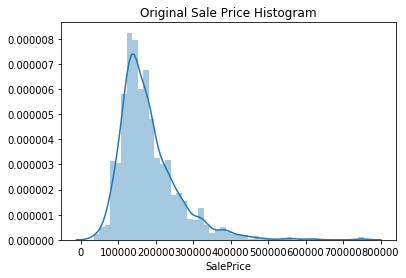

In [3]:
# 히스토그램: 연속형 데이터에 대한 구간의 값
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice']);

'Log Transformed Sale Price Histogram'

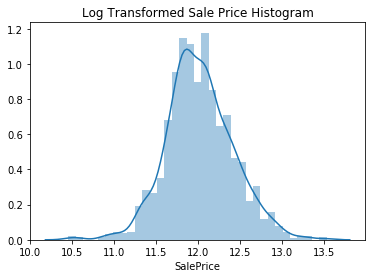

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice);

SalePrice 로그 변환<br>
Null 이 너무 많은 컬럼(500개 이상)들과 불필요한 컬럼 삭제<br>
Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체<br>
Null 값이 있는 피처명과 타입을 추출

In [5]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 너무 많은 컬럼(500개 이상)들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(),inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])


## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


'get_dummies() 수행 전 데이터 Shape'<br>
'get_dummies() 수행 후 데이터 Shape'<br>
'Null 피처의 Type'

In [6]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape) # one hot encoding을 실행하기 위해 get_dummies를 실행
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index]) # 처리 후 결측치가 존재하지않음


get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


### 선형 회귀 모델의 학습/예측/평가

In [7]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

LinearRegression, Ridge, Lasso 학습, 예측, 평가 <= test size: 20%, random seed: 156

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154405, 0.12750846334053045, 0.17628250556471395]

In [9]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

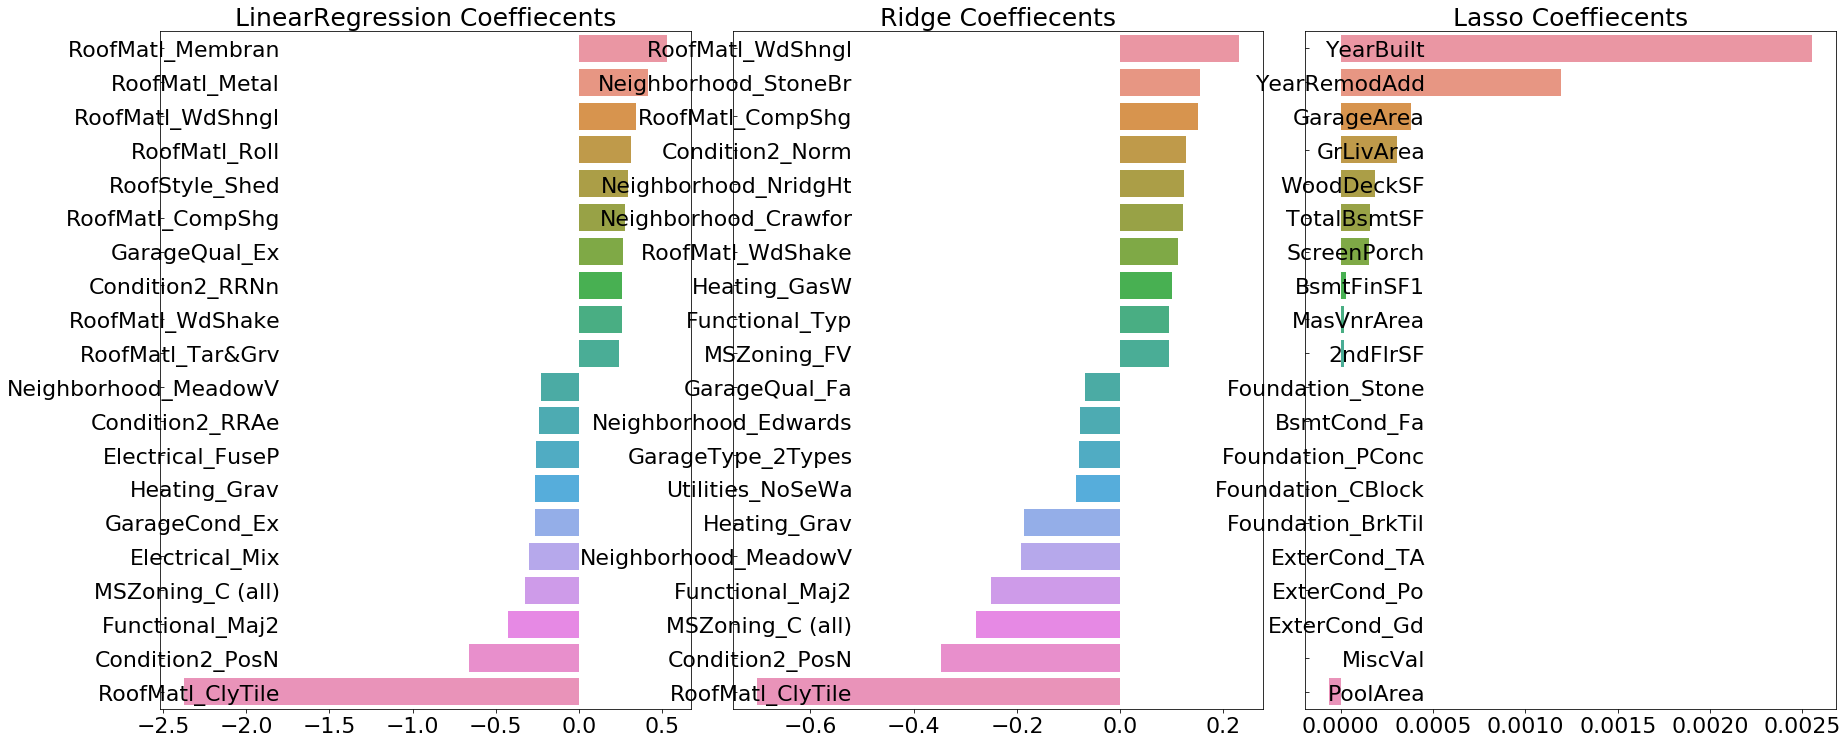

In [10]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [11]:
def get_avg_rmse_cv(models):
    # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. scoring: neg_mean_squared_error, cv: 5. 모델별 CV RMSE값과 평균 RMSE 출력
    pass    

# 앞에서 학습한 모델의 CV RMSE값 출력           


#### * 하이퍼 파라미터 튜닝

In [12]:
def get_best_params(model, params):
    # scoring: neg_mean_squared_error, cv: 5
    pass

앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. <br>

모든 모델의 RMSE 출력 <br>

모든 모델의 회귀 계수 시각화 


#### * 데이터 왜곡 로그 변환 후 성능 평가

object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.<br>

house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 <br>

skew 정도가 1 이상인 컬럼들만 추출. 


Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,<br>

피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력


앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. <br>

모든 모델의 RMSE 출력<br>

모든 모델의 회귀 계수 시각화 


#### * 이상치 제거

산점도 시각화


GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. <br>

DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 


앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. <br>

모든 모델의 RMSE 출력<br>

모든 모델의 회귀 계수 시각화 


### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [ ]:
def get_rmse_pred(preds):
    pass

# 최종 혼합 모델의 RMSE: 0.10007 
# Ridge 모델의 RMSE: 0.10345 
# Lasso 모델의 RMSE: 0.10024

개별 모델의 학습<br>

개별 모델 예측<br>

개별 모델 예측값 혼합으로 최종 예측값 도출 (ridge: 40%, lasso: 60%)<br>

최종 혼합 모델, 개별모델의 RMSE 값 출력
